# Topic Contiguity 

Topic contiguity refers to the relationship of topics to each other in practice, not to their similarity. From the perspective of an associationist epistemology, contiguity is the opposite of similarity. Contiguous topics are those that co-occur frequently enough to suggest "syndromes." For example, if the topics of genetic engineering and acquaculture are contiguous, this suggests an assemblage of practices relating to the application of a kind of knowledge to a specific industry. We use pointwise mutual information  to surface topic contiguity, similar to how this concept is used in association rule mining.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np

## Configuration

In [2]:
data_prefix = 'jstor_hyperparameter_demo'
topic_model_suffix = '_NMF'
# topic_model_suffix = ''
topic_glosses = ['Bayesian models', 'French', 'MCMC', 'priors', 'economics', 'random effects', 'variable selection',
                 'empirical Bayes', 'env biology', 'genetics']

In [3]:
db_dir = './db'

## Import Topic Data

We import our previously generated model.

In [4]:
LABELS = pd.read_csv(f"{db_dir}/{data_prefix}-LABELS.csv").set_index('doc_id')
VOCAB = pd.read_csv(f"{db_dir}/{data_prefix}-VOCAB.csv").set_index('term_str')
BOW = pd.read_csv(f"{db_dir}/{data_prefix}-BOW.csv").set_index(['doc_id','term_str'])
TOPICS = pd.read_csv(f"{db_dir}/{data_prefix}-TOPICS{topic_model_suffix}.csv").set_index('topic_id')
THETA = pd.read_csv(f"{db_dir}/{data_prefix}-THETA{topic_model_suffix}.csv").set_index('doc_id')
THETA.columns.name = 'topic_id'
THETA.columns = [int(col) for col in THETA.columns] # Should change columns to strings
PHI = pd.read_csv(f"{db_dir}/{data_prefix}-PHI{topic_model_suffix}.csv").set_index('topic_id')
PHI.columns.name = 'term_str'

In [5]:
if len(topic_glosses) > 0:
    TOPICS['gloss'] = topic_glosses # THIS SHOULD BE DONE EARLIER IN THE PIPELINE
else:
    TOPICS['gloss'] = TOPICS.topwords.str.extract(r'^(.{20})')

In [6]:
n_topics = len(TOPICS)
topic_cols = [t for t in range(n_topics)]

# Compute Contiguity

## By Correlation

In [7]:
topic_pairs = THETA.corr().stack().to_frame('topic_corr')
topic_pairs.index.names = ['t1', 't2']
topic_pairs = topic_pairs.loc[topic_pairs.apply(lambda x: x.name[0] < x.name[1], 1)]
topic_pairs['z_score'] = (topic_pairs.topic_corr - topic_pairs.topic_corr.mean()) / topic_pairs.topic_corr.std()
topic_pairs['t1_gloss'] = topic_pairs.apply(lambda x: TOPICS.loc[x.name[0]].gloss, 1)
topic_pairs['t2_gloss'] = topic_pairs.apply(lambda x: TOPICS.loc[x.name[1]].gloss, 1)

In [8]:
topic_pairs.sort_values('z_score', ascending=False)

topic_corr   z_score            t1_gloss            t2_gloss
t1 t2                                                              
6  7     0.097966  2.096024  variable selection     empirical Bayes
0  2     0.069323  1.647788     Bayesian models                MCMC
   5     0.045801  1.279689     Bayesian models      random effects
3  6     0.038231  1.161238              priors  variable selection
2  6     0.016686  0.824074                MCMC  variable selection
5  7     0.015219  0.801125      random effects     empirical Bayes
8  9     0.007242  0.676280         env biology            genetics
6  9     0.005250  0.645117  variable selection            genetics
3  7     0.004493  0.633272              priors     empirical Bayes
7  9     0.001965  0.593711     empirical Bayes            genetics
3  5    -0.000378  0.557037              priors      random effects
2  5    -0.000677  0.552358                MCMC      random effects
1  7    -0.004168  0.497734              French     empirical Bayes
5  6    -0.004901  0.486266      random effects  variable selection
1  3    -0.011072  0.389693              French              priors
2  9    -0.012360  0.369540                MCMC            genetics
6  8    -0.013321  0.354488  variable selection         env biology
1  4    -0.021988  0.218872              French           economics
0  6    -0.027794  0.128002     Bayesian models  variable selection
4  9    -0.028122  0.122872           economics            genetics
1  9    -0.029539  0.100703              French            genetics
4  8    -0.032969  0.047028           economics         env biology
1  2    -0.034204  0.027695              French                MCMC
5  8    -0.034222  0.027415      random effects         env biology
4  5    -0.036030 -0.000874           economics      random effects
2  3    -0.036570 -0.009324                MCMC              priors
1  6    -0.038201 -0.034855              French  variable selection
4  6    -0.038249 -0.035597           economics  variable selection
1  8    -0.039184 -0.050229              French         env biology
4  7    -0.039842 -0.060536           economics     empirical Bayes
5  9    -0.040199 -0.066113      random effects            genetics
1  5    -0.040253 -0.066969              French      random effects
7  8    -0.041499 -0.086460     empirical Bayes         env biology
0  9    -0.049768 -0.215872     Bayesian models            genetics
3  9    -0.051022 -0.235496              priors            genetics
2  4    -0.055111 -0.299470                MCMC           economics
   7    -0.057940 -0.343740                MCMC     empirical Bayes
3  4    -0.063863 -0.436437              priors           economics
2  8    -0.067180 -0.488350                MCMC         env biology
3  8    -0.084087 -0.752919              priors         env biology
0  7    -0.114099 -1.222584     Bayesian models     empirical Bayes
   3    -0.142843 -1.672402     Bayesian models              priors
   8    -0.148066 -1.754125     Bayesian models         env biology
   4    -0.224053 -2.943256     Bayesian models           economics
   1    -0.257229 -3.462417     Bayesian models              French

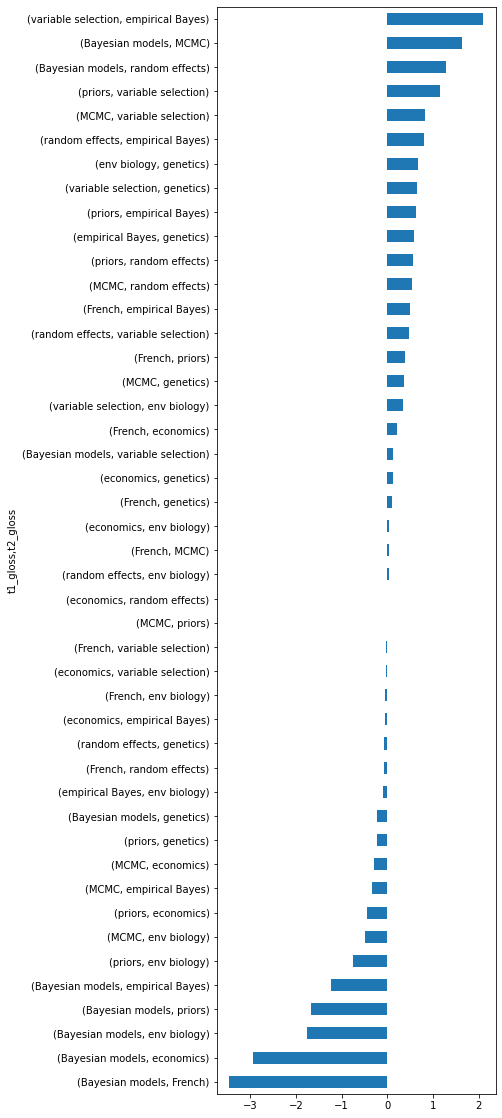

In [9]:
topic_pairs.reset_index().set_index(['t1_gloss','t2_gloss']).z_score.sort_values()\
    .plot.barh(figsize=(5, n_topics * 2), legend=False);

## Create Network

In [10]:
import pydot
from IPython.display import SVG, display

In [11]:
def show_graph(thresh = 1):
    
    graph = pydot.Dot('my_graph', graph_type='graph')

    nodes = []
    for i in topic_pairs[topic_pairs.z_score >= thresh].index:
        z = topic_pairs.loc[i].z_score.round(2)    
        nodes.append(i[0])
        nodes.append(i[1])
        w = z**2
        graph.add_edge(pydot.Edge(i[0], i[1], label=z, color='lightgray', 
                                  fontsize=10, 
                                  fontcolor='green',
                                  fontname='Arial'))

    for node in list(set(nodes)):
        node_gloss = 'T' + str(node) + ": " + TOPICS.loc[node, 'gloss']
        graph.add_node(pydot.Node(node, label=node_gloss, shape='plain', fontname='Arial'))

    display(SVG(graph.create_svg()))

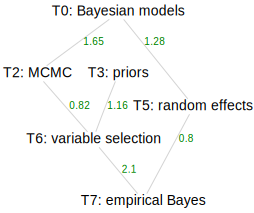

In [13]:
show_graph(.7)